# IMPORT

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from tqdm import tqdm
import zipfile
from google.colab import drive
import shutil
from IPython.display import Audio
import random

import torch.nn as nn
import torchaudio

from torch.utils.data import Dataset, DataLoader

Reproducibility

In [2]:
# Set the random seed
random.seed(8)

# FUNCTIONS

In [3]:
def download_dataset (link_dataset, destination_dir, gdrive_link, extract_dir):
  file_id = os.path.split(link_dataset)[0].split('/')[-1]  # Take the file_id (Ex. "https://drive.google.com/file/d/1BMj4BGXxIMzsd-GYSAEMpB7CF0XB87UT/view?usp=sharing" => file_id: 1BMj4BGXxIMzsd-GYSAEMpB7CF0XB87UT)
  download_link = gdrive_link + file_id # Create the path for gdown (Ex. https://drive.google.com/uc?id={YOUR_FILE_ID})

  # Try to download the dataset if the dataset was not already downloaded
  try:
    if not(os.path.exists(extract_dir)):
      gdown.download(
          download_link,
          destination_dir,
          quiet=False)
    else:
      print("Dataset already downloaded")

  except Exception as error:
    print ("Error in downloading:")
    print(error)

  # Try to unzip the zipped file downloaded
  try:
    if not(os.path.exists(extract_dir)):
      with zipfile.ZipFile(destination_dir, 'r') as zip:

        os.makedirs(extract_dir)

        list_file = zip.namelist()  # Create a list of all the file in the zipped (Ex. ['file1.txt', 'dir1/file2.txt', ... ])
        file_len = len(list_file) # Get the length of the list (Ex. 5)

        with tqdm(total = file_len, desc= "Unzipping...") as pbar:

          for file in list_file:

            zip.extract(file, extract_dir)
            pbar.update(1)

          os.remove(destination_dir)
    else:
      print("Dataset already unzipped")

  except Exception as error:
    print ("Error in unzipping:")
    print(error)

In [4]:
def counter_classes (classes, dataset_dir):

  n_file = {class_:0 for class_ in classes}

  for class_ in classes:
    class_dir = os.path.join(dataset_dir, class_)
    n_file[class_] = len(os.listdir(class_dir))

  return n_file

In [11]:
def dataset_split(dataset_dir, extract_dir, train_perc, test_perc, val_perc):

  split_dir = ['train', 'test', 'val']
  new_dataset_dir = os.path.join(extract_dir, 'EMOVO_split')
  os.makedirs(new_dataset_dir, exist_ok=True)
  for split in split_dir:
    os.makedirs(os.path.join(new_dataset_dir, split), exist_ok=True)

  classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
  tmp_dir = os.path.join(extract_dir, 'EMOVO_tmp')
  os.makedirs(tmp_dir, exist_ok=True)
  for class_ in classes:
    os.makedirs(os.path.join(tmp_dir, class_), exist_ok=True)

  # Merge the entire Dataset
  try:
    if (os.path.exists(dataset_dir)):

      subdirectories = os.listdir(dataset_dir)

      for subdir in subdirectories:
        if not(subdir == 'documents'):
          for filename in os.listdir(os.path.join(dataset_dir, subdir)):
            filename_class = filename.split('-')[0]
            file_path = os.path.join(dataset_dir, subdir, filename)
            new_path = os.path.join(tmp_dir, filename_class, filename)

            # Move the file to the merged directory
            shutil.move(file_path, new_path)

      n_file = counter_classes(classes, tmp_dir)

      # Data Split randomly
      for class_ in classes:
        random_vector = random.sample(range(1, n_file[class_] + 1), n_file[class_])

        n_train = (n_file[class_] * train_perc)
        n_test = (n_file[class_] * test_perc)
        n_val = (n_file[class_] * val_perc)

        train_index = random_vector[:int(n_train)]
        test_index = random_vector[int(n_train):int(n_train) + int(n_test)]
        val_index = random_vector[int(n_train) + int(n_test):]

        for index in train_index:
          filename = os.listdir(os.path.join(tmp_dir, class_))
          filename_i = filename[index-1]
          source_dir = os.path.join(tmp_dir, class_, filename_i)
          target_dir = os.path.join(new_dataset_dir, 'train', filename_i)
          shutil.copy(source_dir, target_dir)

        for index in test_index:
          filename = os.listdir(os.path.join(tmp_dir, class_))
          filename_i = filename[index-1]
          source_dir = os.path.join(tmp_dir, class_, filename_i)
          target_dir = os.path.join(new_dataset_dir, 'test', filename_i)
          shutil.copy(source_dir, target_dir)

        for index in val_index:
          filename = os.listdir(os.path.join(tmp_dir, class_))
          filename_i = filename[index-1]
          source_dir = os.path.join(tmp_dir, class_, filename_i)
          target_dir = os.path.join(new_dataset_dir, 'val', filename_i)
          shutil.copy(source_dir, target_dir)

    else:
      print("Dataset not found")

  except Exception as error:
    print ("Error in dataset reordering:")
    print(error)

# CLASSES

In [25]:
class EMOVO_Dataset(Dataset):

  def __init__(self, dataset_dir, transform=None):

    self.dataset_dir = dataset_dir
    self.transform = transform
    self.classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
    self.data = [] # Waw Audio as tensors
    self.labels = [] # Labels of the data

    file_list = os.listdir(dataset_dir)
    for filename in file_list:
      path = os.path.join(dataset_dir, filename)
      tensor, sample_rate = torchaudio.load(path)
      class_ = self.classes.index(filename.split('-')[0])
      self.data.append((tensor,sample_rate))
      self.labels.append(class_)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    data = self.data[idx]
    label = self.labels[idx]

    return data, label

  def get_info(self):
    n_sample = [ self.labels.count(class_) for class_ in range(len(classes))]
    return n_sample

# MAIN

## Download and Split Dataset

In [12]:
link_dataset = "https://drive.google.com/file/d/1nzKBta2M3khw7Ql_S7atYg-H-bWDiOxr/view?usp=drive_link"
destination_dir = "/content/emovo.zip"
gdrive_link = "https://drive.google.com/uc?export=download&id="
extract_dir = '/content/dataset'
emovo_data_dir = '/content/dataset/EMOVO'

download_dataset(link_dataset, destination_dir, gdrive_link, extract_dir)

dataset_split(emovo_data_dir, extract_dir, 0.7, 0.2, 0.1)

Dataset already downloaded
Dataset already unzipped


## Dataset Exploration

In [26]:
train_path = os.path.join(extract_dir, 'EMOVO_split', 'train')
test_path = os.path.join(extract_dir, 'EMOVO_split', 'test')
val_path = os.path.join(extract_dir, 'EMOVO_split', 'val')

train_dataset = EMOVO_Dataset(train_path)
test_dataset = EMOVO_Dataset(test_path)
val_dataset = EMOVO_Dataset(val_path)

Example of audio

Tensor of shape: torch.Size([2, 149504]) Sample Rate: 48000
Class: rab 



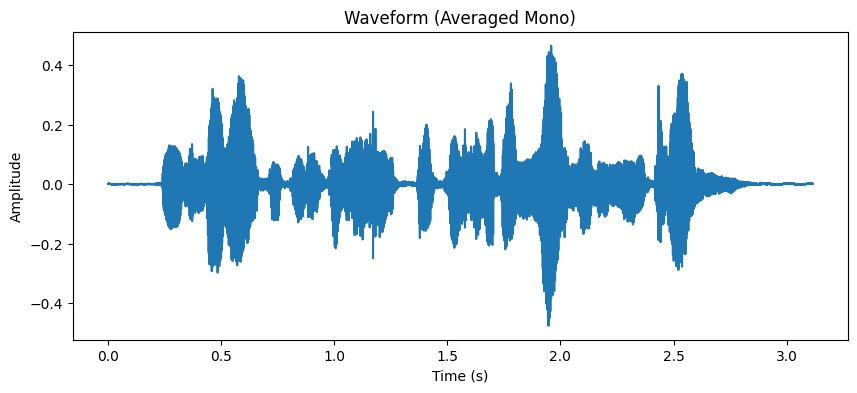

In [77]:
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
random_num = random.randint(1, train_dataset.__len__())
data, label = train_dataset[random_num]

print("Tensor of shape:",data[0].shape, "Sample Rate:", data[1])
print("Class:", classes[label], "\n")

# Waveform
# Compute the average of both channels to get a mono waveform
mono_waveform = data[0].mean(dim=0)
num_samples = mono_waveform.shape[0]
sample_rate = data[1]
time_axis = np.linspace(0, num_samples / sample_rate, num_samples)

# Play the audio
display(Audio(mono_waveform.numpy(), rate=sample_rate))

# Plot the averaged (mono) waveform
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mono_waveform.numpy())
plt.title('Waveform (Averaged Mono)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
